# DEEP LEARNING APPROACH

Student 1: Sara Martín (NIU:1669812)

Student 2: Amelia Gomez (NIU:1631745)

Student 3: Aina Navarro (NIU:1670797)

Student 4: Lara Rodríguez (NIU: 1667906)

## Downloads, libraries and functions

In [ ]:
!git clone https://github.com/saraxmartin/NegExES.git
%cd "/content/NegExES"
!git pull

In [2]:
import os
import re
import unicodedata
import json
import spacy
import random
import nltk
nltk.download("punkt")
nlp = spacy.load('en_core_web_sm')

import numpy as np
import pandas as pd
import pprint, time

from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#!pip install wandb

In [4]:
# Connect wandb account
# wandb.login(key="8090840539532ccc2f8ea5c1595fde6dbb57bf56")

# Data pre-processing


Import the data (JSON) and create training and test datasets


In [5]:
train_data_path = "/content/NegExES/data/negacio_train_v2024.json"
test_data_path = "/content/NegExES/data/negacio_test_v2024.json"

# Read files
with open(train_data_path, 'r') as file:
    train_json_data = file.read()
    train_data = json.loads(train_json_data)

with open(test_data_path, 'r') as file:
    test_json_data = file.read()
    test_data = json.loads(test_json_data)

def extract_data(data, train=False):
    """
    Extracts the data from the JSON file.
    Returns:
        corpus: list of texts
        ground_truth: list of dictionaries (one for each text)
            with the true labels for negations/uncertainities and
            their scopes.
    """
    corpus = []
    ground_truth = []
    for item in data:
        text = item['data']['text']
        corpus.append(text)
        predictions = item['predictions']
        text_gt = {"NEG":[],"UNC":[],"NSCO":[],"USCO":[]}
        for prediction in predictions:
            for result in prediction['result']:
                value = result['value']
                start = value['start']
                end = value['end']
                labels = value['labels']
                extracted_text = text[start:end]
                for label in labels:
                    text_gt[label].append((start,end))

            ground_truth.append(text_gt)

    return corpus, ground_truth

x_train, gt_train = extract_data(train_data, train=True)
x_test, gt_test = extract_data(test_data, train=False)

print("Length training data:", len(x_train))
print("Length test data:", len(x_test))

Length training data: 254
Length test data: 64


Create y_train and y_test from gt_train and gt_test

In [6]:
def get_token_indices(text):
    tokens = nltk.word_tokenize(text)
    indices = []
    current_index = 0
    for token in tokens:
        start = text.find(token, current_index)
        end = start + len(token)
        indices.append((start, end))
        current_index = end
    return tokens, indices

def is_within_indices(index,indices_list):
    for idx in indices_list:
        if idx[0] <= index[0] <= idx[1] and idx[0] <= index[1] <= idx[1]:
            return True
    return False

def create_y_data(text_indices,gt):
    y_data = []
    for index in text_indices:
        if is_within_indices(index,gt["NEG"]):
            y_data.append("NEG")
        elif is_within_indices(index,gt["UNC"]):
            y_data.append("UNC")
        elif is_within_indices(index,gt["NSCO"]):
            y_data.append("NSCO")
        elif is_within_indices(index,gt["USCO"]):
            y_data.append("USCO")
        else:
            y_data.append("O")
    return y_data

X_train_tokens = []
y_train = []

for i,text in enumerate(x_train):
    text_tokens, text_indices = get_token_indices(text)
    X_train_tokens.append(text_tokens)
    y_data = create_y_data(text_indices,gt_train[i])
    y_train.append(y_data)

X_test_tokens = []
y_test = []

for i,text in enumerate(x_test):
    text_tokens, text_indices = get_token_indices(text)
    X_test_tokens.append(text_tokens)
    y_data = create_y_data(text_indices,gt_test[i])
    y_test.append(y_data)

Perform BIO and BIESO tagging

In [7]:
import sys
sys.path.append('/content/NegExES/')

from bio_bieso_tagging import BIO_tagging, BIESO_tagging

y_train_bio = BIO_tagging(y_train)
y_test_bio = BIO_tagging(y_test)

y_train_bieso = BIESO_tagging(y_train)
y_test_bieso = BIESO_tagging(y_test)

Create new datasets with format [(text,labels),...,(text,labels)]

In [8]:
def change_format(list_texts, list_tags):
    new_format = []
    for text, tags in zip(list_texts, list_tags):
        new_format.append((text,tags))
    return new_format

def words_to_index(texts):
  OOV_TOKEN = "<OOV>"
  word_to_ix = {OOV_TOKEN: 0}
  for sent in texts:
      for word in sent:
          if word not in word_to_ix:
              word_to_ix[word] = len(word_to_ix)
  return word_to_ix

In [34]:
# Get tag_to_ix and ix_to_tag dictionaries
tag_to_ix = {"O": 0, "NEG": 1, "UNC":2, "NSCO":3, "USCO":4, "<OOV>":5}
tag_to_ix_bio = {"O": 0, "B_NEG": 1, "I_NEG": 2, "B_UNC":3, "I_UNC":4, "B_NSCO":5, "I_NSCO":6, "B_USCO":7, "I_USCO":8, "<OOV>":9}
tag_to_ix_bieso = {"O": 0, "B_NEG:": 1, "I_NEG": 2, "E_NEG": 3, "S_NEG": 4, "B_UNC": 5, "I_UNC": 6, "E_UNC": 7, "S_UNC": 8, "B_NSCO": 9, "I_NSCO": 10, "E_NSCO": 11, "S_NSCO": 12, "B_USCO": 13, "I_USCO": 14, "E_USCO": 15, "S_USCO": 16, "<OOV>":17}

ix_to_tag = {v:k for k,v in tag_to_ix.items()}
ix_to_tag_bio = {v:k for k,v in tag_to_ix_bio.items()}
ix_to_tag_bieso = {v:k for k,v in tag_to_ix_bieso.items()}

# Get word_to_ix dictionaries
word_to_ix = words_to_index(X_train_tokens)
# word_to_ix_test = words_to_index(X_test_tokens)

# Baseline train, test sets
train_base = change_format(X_train_tokens, y_train)
test_base = change_format(X_test_tokens, y_test)

# BIO train, test sets
train_bio = change_format(X_train_tokens, y_train_bio)
test_bio = change_format(X_test_tokens, y_test_bio)

# BIESO train, test sets
train_bieso = change_format(X_train_tokens, y_train_bieso)
test_bieso = change_format(X_test_tokens, y_test_bieso)

# Implementation

### Functions

In [44]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix.get(w, to_ix["<OOV>"]) for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [45]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

In [46]:
def train(model, train_set, optimizer, loss_function, word_to_ix, tag_to_ix, N_EPOCHS):
  train_losses = []
  train_accuracies = []

  for epoch in range(N_EPOCHS):

      epoch_loss = 0.0
      epoch_acc = 0.0

      # get all sentences and corresponding tags in the training data
      for sentence, tags in train_set:

          # zero the gradients
          model.zero_grad()

          # zero the hidden state of the LSTM, this detaches it from its history
          model.hidden = model.init_hidden()

          # prepare the inputs for processing by out network,
          # turn all sentences and targets into Tensors of numerical indices
          sentence_in = prepare_sequence(sentence, word_to_ix)
          targets = prepare_sequence(tags, tag_to_ix)

          # forward pass to get tag scores
          tag_scores = model(sentence_in)

          # compute the loss, and gradients
          loss = loss_function(tag_scores, targets)
          acc = categorical_accuracy(tag_scores, targets)

          epoch_loss += loss.item()
          epoch_acc += acc.item()

          loss.backward()

          # update the model parameters with optimizer.step()
          optimizer.step()

      train_losses.append(epoch_loss)
      train_accuracies.append(epoch_acc)

      # print out avg loss per 20 epochs
      print("Epoch: %d, loss: %1.5f, accuracy: %1.5f" % (epoch+1, epoch_loss/len(train_set), epoch_acc/len(train_set)))

      # Save to wandb
      # wandb.log({'epoch': epoch, 'train/loss': epoch_loss/len(train_set), 'train/accuracy': epoch_acc/len(train_set)})

  return train_losses, train_accuracies

In [47]:
def plot_training_process(train_losses,train_accuracies):
    plt.figure(figsize=(12, 5))

    # Plotting the training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, N_EPOCHS + 1), train_losses, marker='o', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, N_EPOCHS + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [48]:
from tabulate import tabulate

def evaluate(model, test_data, word_to_ix, tag_to_ix):
    predicted_tags = []
    true_tags = []
    correct = 0
    total = 0

    ix_to_tag = {v:k for k,v in tag_to_ix.items()}

    with torch.no_grad():
        for sentence, tags in test_data:
          sentence_in = prepare_sequence(sentence, word_to_ix)
          targets = prepare_sequence(tags, tag_to_ix)
          tag_scores = model(sentence_in)

          predicted = torch.argmax(tag_scores, dim=1)
          correct += (predicted == targets).sum().item()
          total += len(tags)

          predicted_tags.extend([ix_to_tag[ix.item()] for ix in predicted])
          true_tags.extend([ix_to_tag[ix.item()] for ix in targets])

    report = classification_report(true_tags, predicted_tags, zero_division=1, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(tabulate(df_report, headers='keys', tablefmt='grid'))

    return correct / total, df_report

In [49]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [50]:
def tag_sentence(model, device, sentence, word_to_ix, ix_to_tag):

    model.eval()

    if isinstance(sentence, str):
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    numericalized_tokens = [word_to_ix[token] for token in tokens]

    token_tensor = torch.LongTensor(numericalized_tokens)

    token_tensor = token_tensor.unsqueeze(-1).to(device)

    predictions = model(token_tensor)

    top_predictions = predictions.argmax(-1)

    predicted_tags = [ix_to_tag[pred.item()] for pred in top_predictions]

    return tokens, predicted_tags

In [51]:
def metrics(y_true, y_pred, dataset='train', model='Baseline'):
   # Flatten both lists
   y_true = [item for row in y_true for item in row]
   y_pred = [item for row in y_pred for item in row]
   if len(y_true) != len(y_pred):
       print("Error: Lists are not of the same length.")
       return None
   report = classification_report(y_true, y_pred, output_dict=True)
   df_report = pd.DataFrame(report).transpose()
   print(f"\n{model} model evaluation for {dataset} dataset:")
   print(tabulate(df_report, headers='keys', tablefmt='grid'))
   plot_metrics(df_report,model,dataset)

### Connect to Weights and Biases
Run every time the hyperparameters have changed.

In [52]:
# Define hyperparameters
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
N_LAYERS = 2
cell_type = 'LSTM'
criterion = 'CrossEntropyLoss' #'NLLLoss', 'CrossEntropyLoss'
learning_rate = 0.1 # 0.1, 0.01, 0.001
optimizer = 'Adagrad' #'Adam', 'SGD', 'RMSprop', 'Adagrad'
N_EPOCHS = 20

NAME = f'{criterion}, opt={optimizer}, lr={learning_rate}'

In [53]:
#wandb.finish()

In [54]:
config_defaults = {
        "learning_rate": learning_rate,
        "epochs": N_EPOCHS,
        "hidden_dim": HIDDEN_DIM,
        "embedding_dim": EMBEDDING_DIM,
        "cell_type": cell_type,
        "optimizer":  optimizer,
        "criterion": criterion,
        "n_layers": N_LAYERS,
        }


#wandb.init(
    # set the wandb project where this run will be logged
    # project="NegMed",
    # track hyperparameters and run metadata
    # config=config_defaults,
    # name = NAME,
    # allow_val_change=True)

## LSTM POS Tagger

In [55]:
class LSTMTagger(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
    super(LSTMTagger, self).__init__()
    self.hidden_dim = hidden_dim

    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

    # The LSTM takes word embeddings as inputs, and outputs hidden states
    # with dimensionality hidden_dim.
    self.lstm = nn.LSTM(embedding_dim, hidden_dim)

    # The linear layer that maps from hidden state space to tag space
    self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    self.hidden = self.init_hidden()

  def init_hidden(self):
    ''' At the start of training, we need to initialize a hidden state;
        there will be none because the hidden state is formed based on perviously seen data.
        So, this function defines a hidden state with all zeroes and of a specified size.'''
    # The axes dimensions are (n_layers, batch_size, hidden_dim)
    return (torch.zeros(1, 1, self.hidden_dim),
            torch.zeros(1, 1, self.hidden_dim))

  def forward(self, sentence):
    embeds = self.word_embeddings(sentence)
    lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
    # get the scores for the most likely tag for a word
    tag_outputs = self.hidden2tag(lstm_out.view(len(sentence), -1))
    tag_scores = F.log_softmax(tag_outputs, dim=1)
    return tag_scores

### LSTM with Baseline tags

In [56]:
INPUT_DIM = len(word_to_ix)
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = len(tag_to_ix)
N_LAYERS = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, OUTPUT_DIM).to(device)

In [57]:
model.apply(init_weights)

LSTMTagger(
  (word_embeddings): Embedding(20712, 128)
  (lstm): LSTM(128, 128)
  (hidden2tag): Linear(in_features=128, out_features=6, bias=True)
)

In [58]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,784,006 trainable parameters


In [59]:
# If using wandb:
# loss_function = {'NLLLoss': nn.NLLLoss, 'CrossEntropyLoss': nn.CrossEntropyLoss}[wandb.config.criterion]()
# optimizer = getattr(torch.optim, wandb.config.optimizer)(model.parameters(), lr=wandb.config.learning_rate)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.1)

model = model.to(device)
loss_function = loss_function.to(device)

Train the model with the train set

In [60]:
N_EPOCHS = 20
train_losses_base, train_accuracies_base = train(model, train_base, optimizer, loss_function, word_to_ix, tag_to_ix, N_EPOCHS)

Epoch: 1, loss: 0.11892, accuracy: 0.73037
Epoch: 2, loss: 0.04473, accuracy: 0.86895
Epoch: 3, loss: 0.03035, accuracy: 0.90602
Epoch: 4, loss: 0.02293, accuracy: 0.92928
Epoch: 5, loss: 0.01879, accuracy: 0.94143
Epoch: 6, loss: 0.01546, accuracy: 0.95545
Epoch: 7, loss: 0.01339, accuracy: 0.95996
Epoch: 8, loss: 0.01121, accuracy: 0.97009
Epoch: 9, loss: 0.00926, accuracy: 0.97411
Epoch: 10, loss: 0.00800, accuracy: 0.97967
Epoch: 11, loss: 0.00690, accuracy: 0.98290
Epoch: 12, loss: 0.00553, accuracy: 0.98630
Epoch: 13, loss: 0.00470, accuracy: 0.98877
Epoch: 14, loss: 0.00404, accuracy: 0.98978
Epoch: 15, loss: 0.00344, accuracy: 0.99181
Epoch: 16, loss: 0.00348, accuracy: 0.99270
Epoch: 17, loss: 0.00300, accuracy: 0.99320
Epoch: 18, loss: 0.00300, accuracy: 0.99385
Epoch: 19, loss: 0.00253, accuracy: 0.99463
Epoch: 20, loss: 0.00203, accuracy: 0.99536


In [61]:
# wandb.finish()

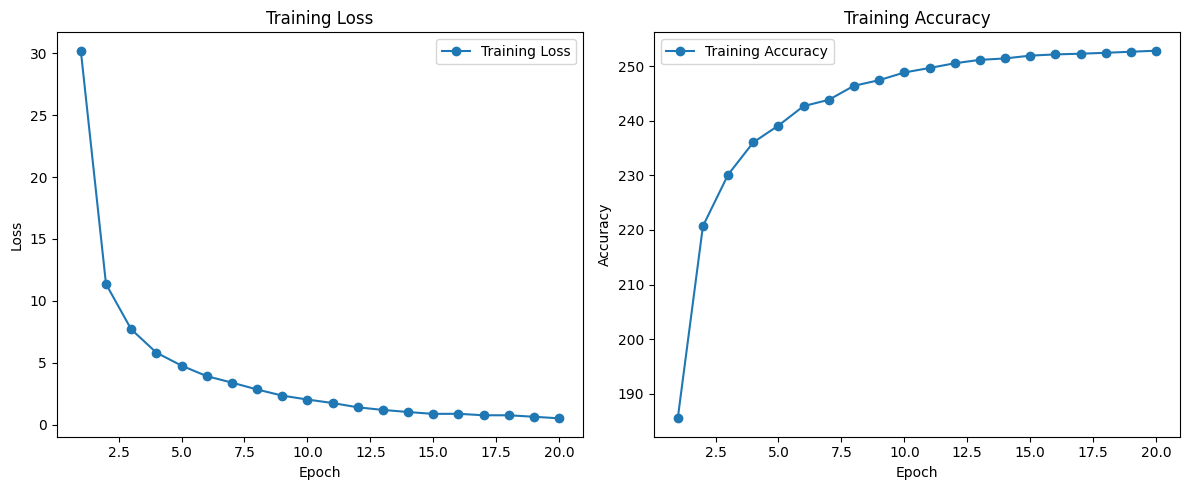

In [62]:
plot_training_process(train_losses_base, train_accuracies_base)

In [63]:
train_accuracy_base, report_base_train = evaluate(model, train_base, word_to_ix, tag_to_ix)
print("Train accuracy:", train_accuracy_base)

+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| NEG          |    0.994703 | 0.997786 |   0.996242 |   4517       |
+--------------+-------------+----------+------------+--------------+
| NSCO         |    0.961258 | 0.999142 |   0.979834 |  13981       |
+--------------+-------------+----------+------------+--------------+
| O            |    0.999902 | 0.997426 |   0.998662 | 224531       |
+--------------+-------------+----------+------------+--------------+
| UNC          |    0.991202 | 0.988304 |   0.989751 |    684       |
+--------------+-------------+----------+------------+--------------+
| USCO         |    0.999032 | 0.995661 |   0.997344 |   2074       |
+--------------+-------------+----------+------------+--------------+
| accuracy     |    0.99749  | 0.99749  |   0.99749  |      0.99749 |
+--------------+----

In [64]:
test_accuracy_base, report_base_test = evaluate(model, test_base, word_to_ix, tag_to_ix)
print("Test accuracy:", test_accuracy_base)

+--------------+-------------+----------+------------+-------------+
|              |   precision |   recall |   f1-score |     support |
+==============+=============+==========+============+=============+
| NEG          |    0.9325   | 0.948305 |   0.940336 |  1180       |
+--------------+-------------+----------+------------+-------------+
| NSCO         |    0.775475 | 0.891036 |   0.829249 |  3570       |
+--------------+-------------+----------+------------+-------------+
| O            |    0.990546 | 0.981606 |   0.986056 | 58388       |
+--------------+-------------+----------+------------+-------------+
| UNC          |    0.801075 | 0.745    |   0.772021 |   200       |
+--------------+-------------+----------+------------+-------------+
| USCO         |    0.785971 | 0.770723 |   0.778272 |   567       |
+--------------+-------------+----------+------------+-------------+
| accuracy     |    0.97332  | 0.97332  |   0.97332  |     0.97332 |
+--------------+-------------+----

### LSTM with BIO tags

In [65]:
INPUT_DIM = len(word_to_ix)
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = len(tag_to_ix_bio)
N_LAYERS = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_bio = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, OUTPUT_DIM).to(device)

In [66]:
model_bio.apply(init_weights)

LSTMTagger(
  (word_embeddings): Embedding(20712, 128)
  (lstm): LSTM(128, 128)
  (hidden2tag): Linear(in_features=128, out_features=10, bias=True)
)

In [67]:
print(f'The model has {count_parameters(model_bio):,} trainable parameters')

The model has 2,784,522 trainable parameters


In [68]:
# If using wandb:
# loss_function = {'NLLLoss': nn.NLLLoss, 'CrossEntropyLoss': nn.CrossEntropyLoss}[wandb.config.criterion]()
# optimizer = getattr(torch.optim, wandb.config.optimizer)(model.parameters(), lr=wandb.config.learning_rate)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model_bio.parameters(), lr=0.1)

model_bio = model_bio.to(device)
loss_function = loss_function.to(device)

Train the model with the train set

In [69]:
N_EPOCHS = 20
train_losses_bio, train_accuracies_bio = train(model_bio, train_bio, optimizer, loss_function, word_to_ix, tag_to_ix_bio, N_EPOCHS)

Epoch: 1, loss: 0.13792, accuracy: 0.70417
Epoch: 2, loss: 0.05172, accuracy: 0.85294
Epoch: 3, loss: 0.03492, accuracy: 0.89943
Epoch: 4, loss: 0.02631, accuracy: 0.91892
Epoch: 5, loss: 0.02113, accuracy: 0.93546
Epoch: 6, loss: 0.01824, accuracy: 0.94566
Epoch: 7, loss: 0.01544, accuracy: 0.95118
Epoch: 8, loss: 0.01307, accuracy: 0.96129
Epoch: 9, loss: 0.01147, accuracy: 0.96811
Epoch: 10, loss: 0.01022, accuracy: 0.97187
Epoch: 11, loss: 0.00878, accuracy: 0.97631
Epoch: 12, loss: 0.00741, accuracy: 0.98242
Epoch: 13, loss: 0.00626, accuracy: 0.98504
Epoch: 14, loss: 0.00546, accuracy: 0.98820
Epoch: 15, loss: 0.00472, accuracy: 0.98834
Epoch: 16, loss: 0.00461, accuracy: 0.98932
Epoch: 17, loss: 0.00423, accuracy: 0.99066
Epoch: 18, loss: 0.00330, accuracy: 0.99321
Epoch: 19, loss: 0.00262, accuracy: 0.99466
Epoch: 20, loss: 0.00214, accuracy: 0.99589


In [70]:
# wandb.finish()

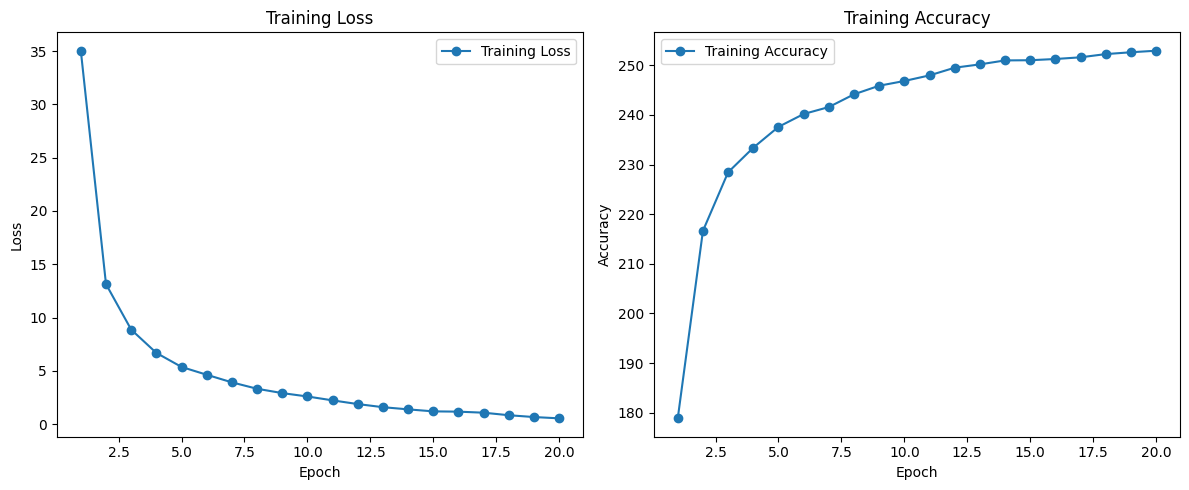

In [71]:
plot_training_process(train_losses_bio, train_accuracies_bio)

In [72]:
train_accuracy_bio, report_bio_train = evaluate(model_bio, train_bio, word_to_ix, tag_to_ix_bio)
print("Train accuracy:", train_accuracy_bio)

+--------------+-------------+----------+------------+---------------+
|              |   precision |   recall |   f1-score |       support |
+==============+=============+==========+============+===============+
| B_NEG        |    0.993461 | 0.99953  |   0.996486 |   4256        |
+--------------+-------------+----------+------------+---------------+
| B_NSCO       |    0.996077 | 0.99828  |   0.997178 |   4070        |
+--------------+-------------+----------+------------+---------------+
| B_UNC        |    1        | 0.964989 |   0.982183 |    457        |
+--------------+-------------+----------+------------+---------------+
| B_USCO       |    0.995546 | 0.993333 |   0.994438 |    450        |
+--------------+-------------+----------+------------+---------------+
| I_NEG        |    0.917857 | 0.984674 |   0.950092 |    261        |
+--------------+-------------+----------+------------+---------------+
| I_NSCO       |    0.985559 | 0.998487 |   0.991981 |   9911        |
+-----

In [73]:
test_accuracy_bio, report_bio_test = evaluate(model_bio, test_bio, word_to_ix, tag_to_ix_bio)
print("Test accuracy:", test_accuracy_bio)

+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| B_NEG        |    0.957371 | 0.96595  |   0.961641 |  1116        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    0.909091 | 0.910798 |   0.909944 |  1065        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.808333 | 0.734848 |   0.769841 |   132        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    0.928571 | 0.806202 |   0.863071 |   129        |
+--------------+-------------+----------+------------+--------------+
| I_NEG        |    0.494118 | 0.65625  |   0.563758 |    64        |
+--------------+-------------+----------+------------+--------------+
| I_NSCO       |    0.765192 | 0.849501 |   0.805146 |  2505        |
+--------------+----

Evaluate the model with the test set

In [74]:
test_sentence, test_tags = test_bio[4]
sentence_in = prepare_sequence(test_sentence, word_to_ix)
targets = prepare_sequence(test_tags, tag_to_ix_bio)
tag_scores = model_bio(sentence_in)

predicted = torch.argmax(tag_scores, dim=1)
predicted_tags = [ix_to_tag_bio[ix.item()] for ix in predicted]

print(test_tags)
print(predicted_tags)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_NEG', 'B_NSCO', 'I_NSCO', 'I_NSCO', 'I_NSCO', 'O', 'O', 'B_NSCO', 'I_NSCO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_UNC', 'I_UNC', 'B_USCO

### LSTM with BIESO tags

In [75]:
INPUT_DIM = len(word_to_ix)
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = len(tag_to_ix_bieso)
N_LAYERS = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_bieso = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, INPUT_DIM, OUTPUT_DIM).to(device)

In [76]:
model_bieso.apply(init_weights)

LSTMTagger(
  (word_embeddings): Embedding(20712, 128)
  (lstm): LSTM(128, 128)
  (hidden2tag): Linear(in_features=128, out_features=18, bias=True)
)

In [77]:
print(f'The model has {count_parameters(model_bieso):,} trainable parameters')

The model has 2,785,554 trainable parameters


In [78]:
# If using wandb:
# loss_function = {'NLLLoss': nn.NLLLoss, 'CrossEntropyLoss': nn.CrossEntropyLoss}[wandb.config.criterion]()
# optimizer = getattr(torch.optim, wandb.config.optimizer)(model.parameters(), lr=wandb.config.learning_rate)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model_bieso.parameters(), lr=0.1)

model_bieso = model_bieso.to(device)
loss_function = loss_function.to(device)

In [79]:
N_EPOCHS = 20
train_losses_bieso, train_accuracies_bieso = train(model_bieso, train_bieso, optimizer, loss_function, word_to_ix, tag_to_ix_bieso, N_EPOCHS)

Epoch: 1, loss: 0.16400, accuracy: 0.57345
Epoch: 2, loss: 0.06850, accuracy: 0.74926
Epoch: 3, loss: 0.04918, accuracy: 0.80279
Epoch: 4, loss: 0.04002, accuracy: 0.83233
Epoch: 5, loss: 0.03319, accuracy: 0.86362
Epoch: 6, loss: 0.02832, accuracy: 0.88576
Epoch: 7, loss: 0.02434, accuracy: 0.90598
Epoch: 8, loss: 0.02062, accuracy: 0.92141
Epoch: 9, loss: 0.01799, accuracy: 0.93384
Epoch: 10, loss: 0.01558, accuracy: 0.94495
Epoch: 11, loss: 0.01434, accuracy: 0.94971
Epoch: 12, loss: 0.01226, accuracy: 0.95857
Epoch: 13, loss: 0.01078, accuracy: 0.96467
Epoch: 14, loss: 0.00954, accuracy: 0.97046
Epoch: 15, loss: 0.00866, accuracy: 0.97178
Epoch: 16, loss: 0.00772, accuracy: 0.97515
Epoch: 17, loss: 0.00712, accuracy: 0.97766
Epoch: 18, loss: 0.00681, accuracy: 0.97957
Epoch: 19, loss: 0.00620, accuracy: 0.98112
Epoch: 20, loss: 0.00545, accuracy: 0.98516


In [80]:
# wandb.finish()

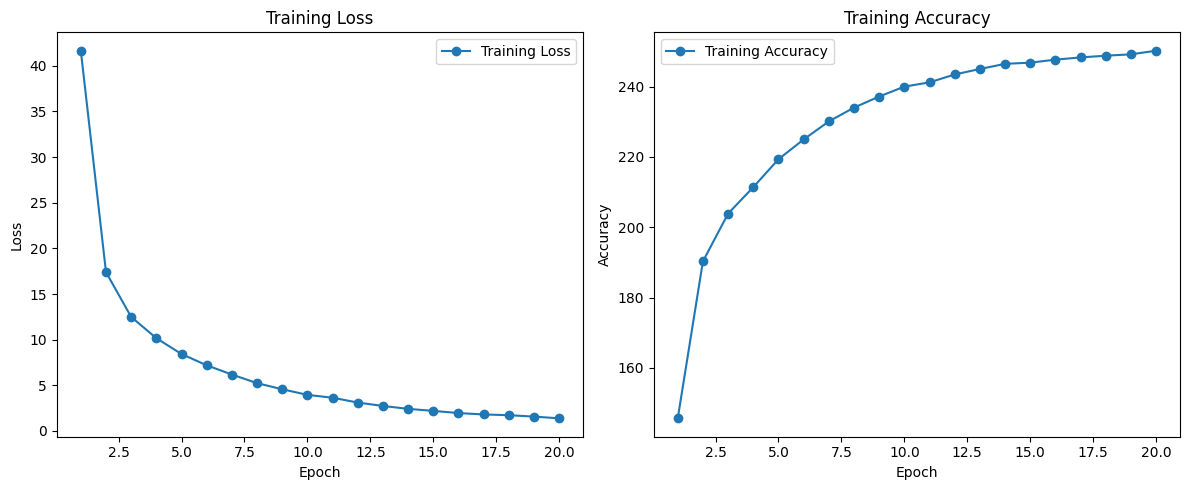

In [81]:
plot_training_process(train_losses_bieso, train_accuracies_bieso)

In [82]:
train_accuracy_bieso, report_bieso_train = evaluate(model_bieso, train_bieso, word_to_ix, tag_to_ix_bieso)
print("Train accuracy:", train_accuracy_bieso)

+--------------+-------------+----------+------------+---------------+
|              |   precision |   recall |   f1-score |       support |
+==============+=============+==========+============+===============+
| <OOV>        |    0.957364 | 0.961089 |   0.959223 |    257        |
+--------------+-------------+----------+------------+---------------+
| B_NSCO       |    0.97914  | 0.993715 |   0.986373 |   3023        |
+--------------+-------------+----------+------------+---------------+
| B_UNC        |    0.96347  | 0.954751 |   0.959091 |    221        |
+--------------+-------------+----------+------------+---------------+
| B_USCO       |    0.997481 | 0.985075 |   0.991239 |    402        |
+--------------+-------------+----------+------------+---------------+
| E_NEG        |    0.965649 | 0.984436 |   0.974952 |    257        |
+--------------+-------------+----------+------------+---------------+
| E_NSCO       |    0.912189 | 0.920939 |   0.916543 |   3023        |
+-----

In [83]:
test_accuracy_bieso, report_bieso_test = evaluate(model_bieso, test_bieso, word_to_ix, tag_to_ix_bieso)
print("Test accuracy:", test_accuracy_bieso)

+--------------+-------------+----------+------------+--------------+
|              |   precision |   recall |   f1-score |      support |
+==============+=============+==========+============+==============+
| <OOV>        |    0.547945 | 0.645161 |   0.592593 |    62        |
+--------------+-------------+----------+------------+--------------+
| B_NSCO       |    0.754209 | 0.851711 |   0.8      |   789        |
+--------------+-------------+----------+------------+--------------+
| B_UNC        |    0.711864 | 0.65625  |   0.682927 |    64        |
+--------------+-------------+----------+------------+--------------+
| B_USCO       |    0.84     | 0.730435 |   0.781395 |   115        |
+--------------+-------------+----------+------------+--------------+
| E_NEG        |    0.56     | 0.677419 |   0.613139 |    62        |
+--------------+-------------+----------+------------+--------------+
| E_NSCO       |    0.38025  | 0.424588 |   0.401198 |   789        |
+--------------+----

# Results

## Hyperparameters exploration

In [104]:
# Get dataframes
df_trainloss = pd.read_csv('/content/NegExES/results_dl/train_loss.csv')
df_trainacc = pd.read_csv('/content/NegExES/results_dl/train_acc.csv')

In [105]:
# Drop redundant columns
cols_to_drop = [col for col in df_trainacc.columns if col.endswith('MIN') or col.endswith('MAX')]
cols_to_drop.append('Step')
df_trainacc = df_trainacc.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df_trainloss.columns if col.endswith('MIN') or col.endswith('MAX')]
cols_to_drop.append('Step')
df_trainloss = df_trainloss.drop(columns=cols_to_drop)

In [108]:
def plot_hyperparam(df, title):

    df_melted = df.reset_index().melt(id_vars='index', var_name='Execution', value_name='Value')
    df_melted.rename(columns={'index': 'Step'}, inplace=True)

    sns.set(style='whitegrid')
    plt.figure(figsize=(15, 9))

    # Create the line plot
    sns.lineplot(data=df_melted, x='Step', y='Value', hue='Execution', palette='Paired')

    # Add labels and title
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.title(title)

    # Show the plot
    plt.show()

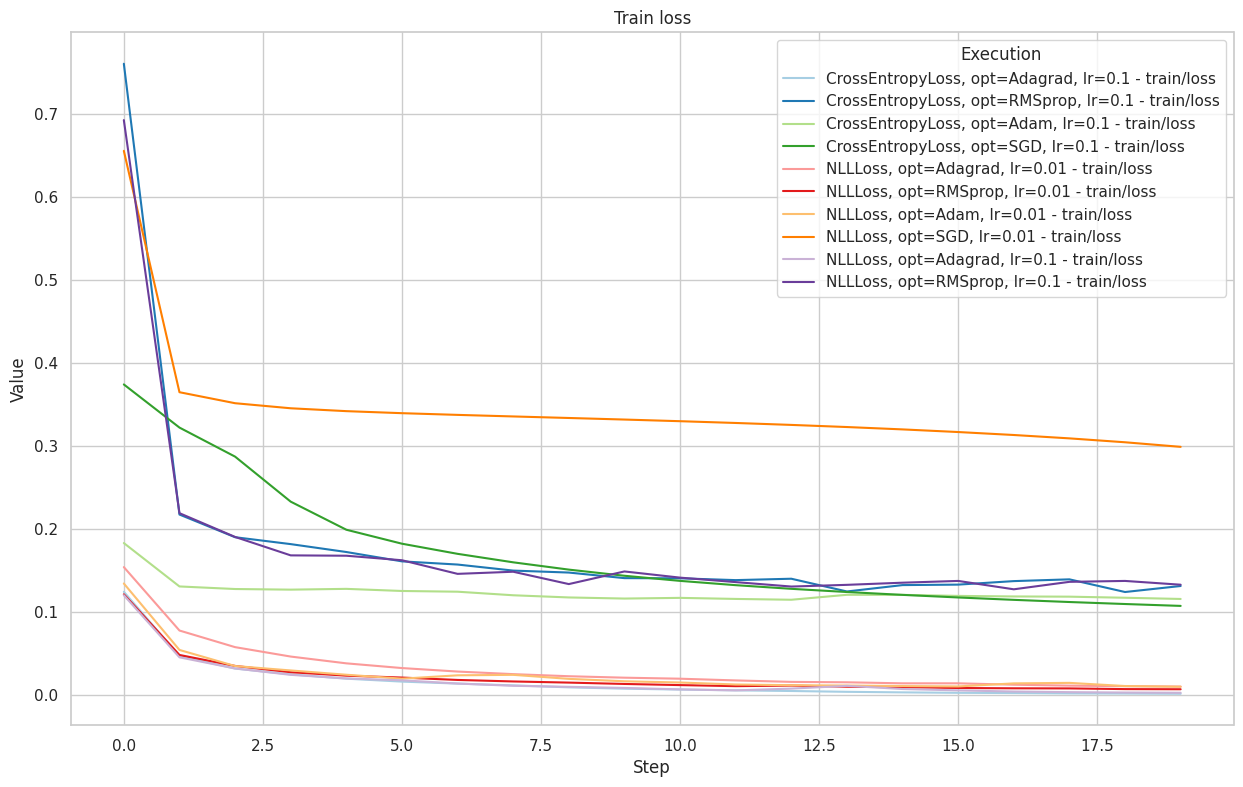

In [109]:
plot_hyperparam(df_trainloss, "Train loss")

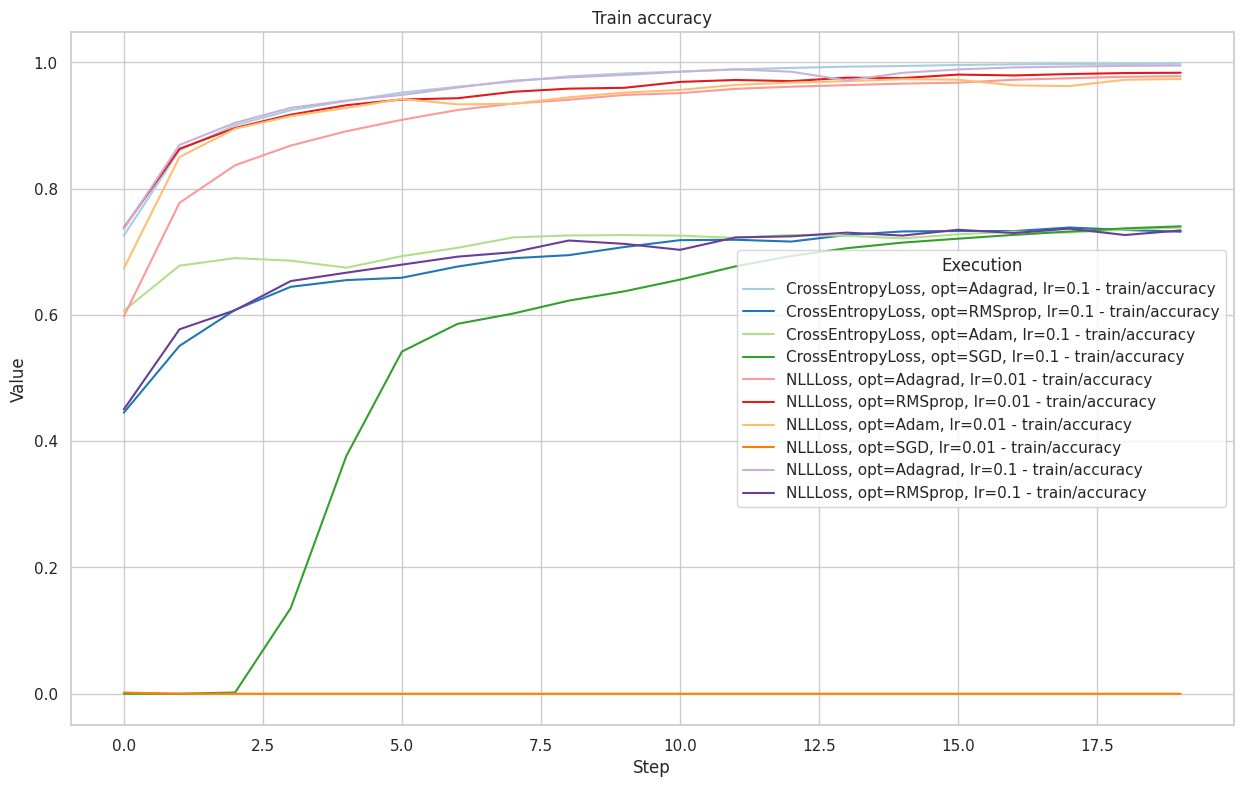

In [110]:
plot_hyperparam(df_trainacc, "Train accuracy")

## Results with best hyperparameters

In [130]:
def plot_report(report_df, title):
    report_df = report_df.drop(columns=['support'])

    report_melted = report_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Value')
    report_melted.rename(columns={'index': 'Class'}, inplace=True)

    min_value = report_melted['Value'].min()

    sns.set(style='whitegrid')
    plt.figure(figsize=(12, 8))

    # Create the barplot
    ax = sns.barplot(data=report_melted, x='Class', y='Value', hue='Metric', palette='Paired')

    # Set y-axis limits
    plt.ylim(min_value-0.01, 1)

    # Add labels and title
    plt.xlabel('Class')
    plt.ylabel('Value')
    plt.title(f'{title} Classification Report')

    # Rotate x labels if needed
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()


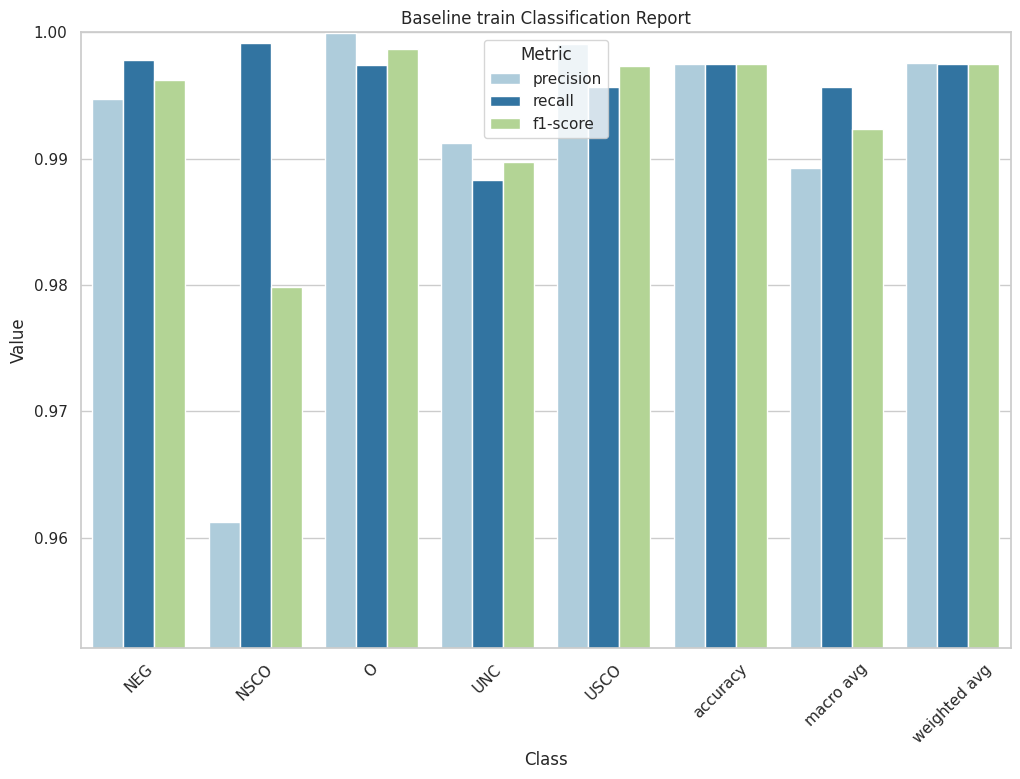

In [131]:
plot_report(report_base_train, "Baseline train")

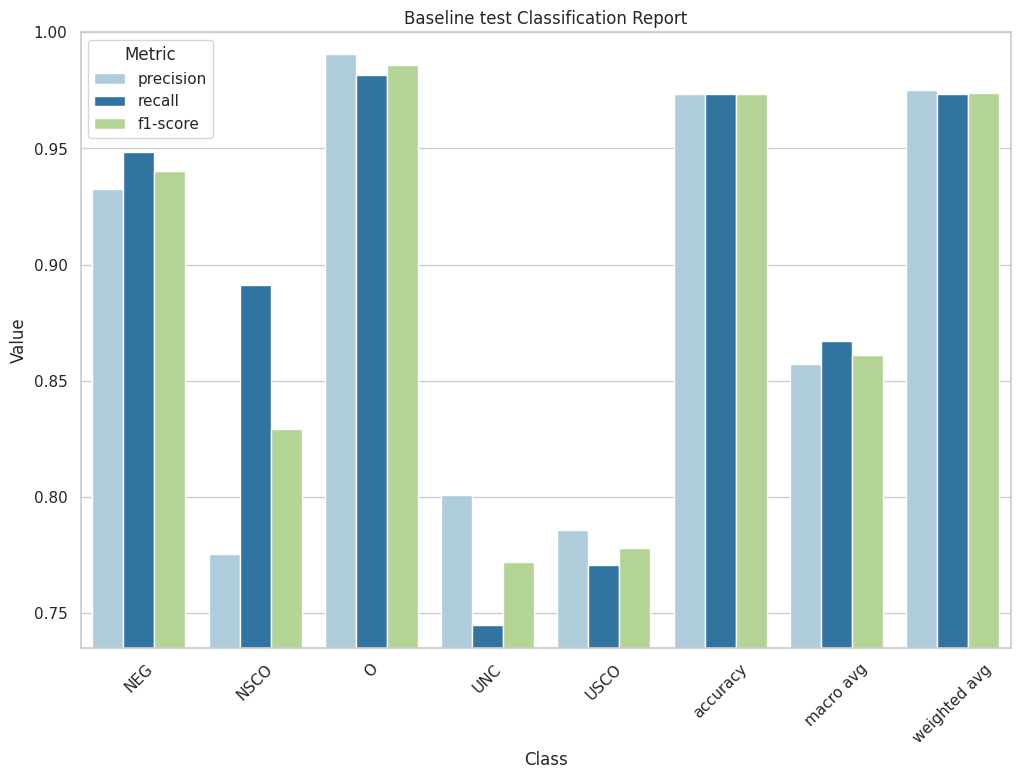

In [132]:
plot_report(report_base_test, "Baseline test")

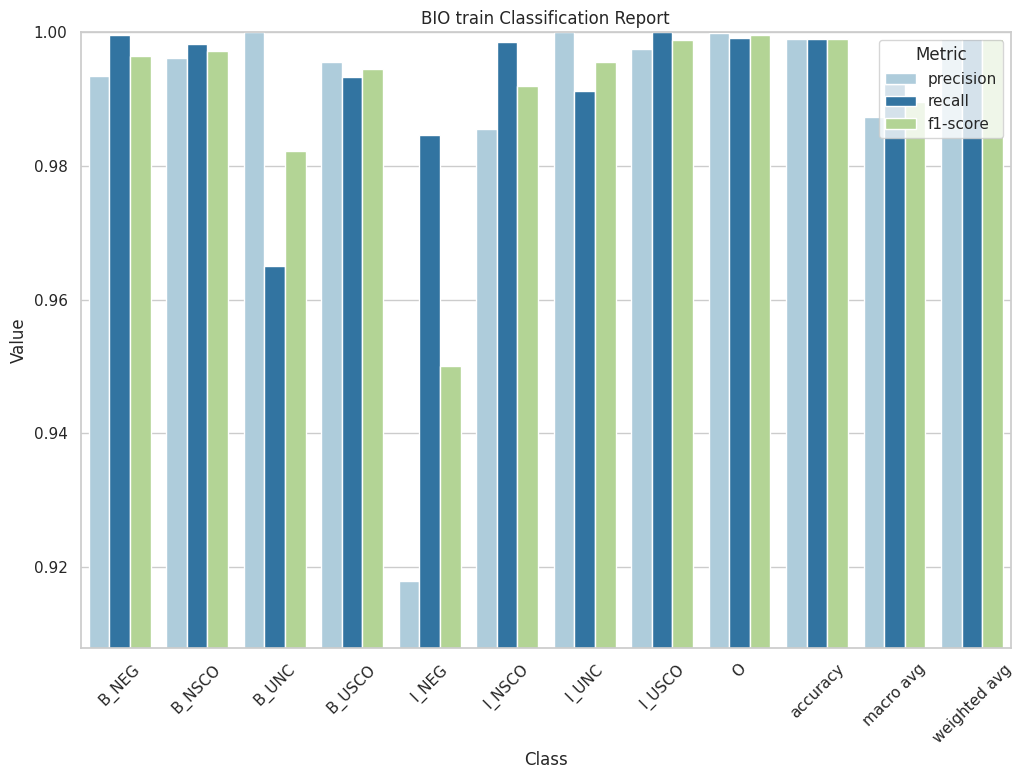

In [133]:
plot_report(report_bio_train, "BIO train")

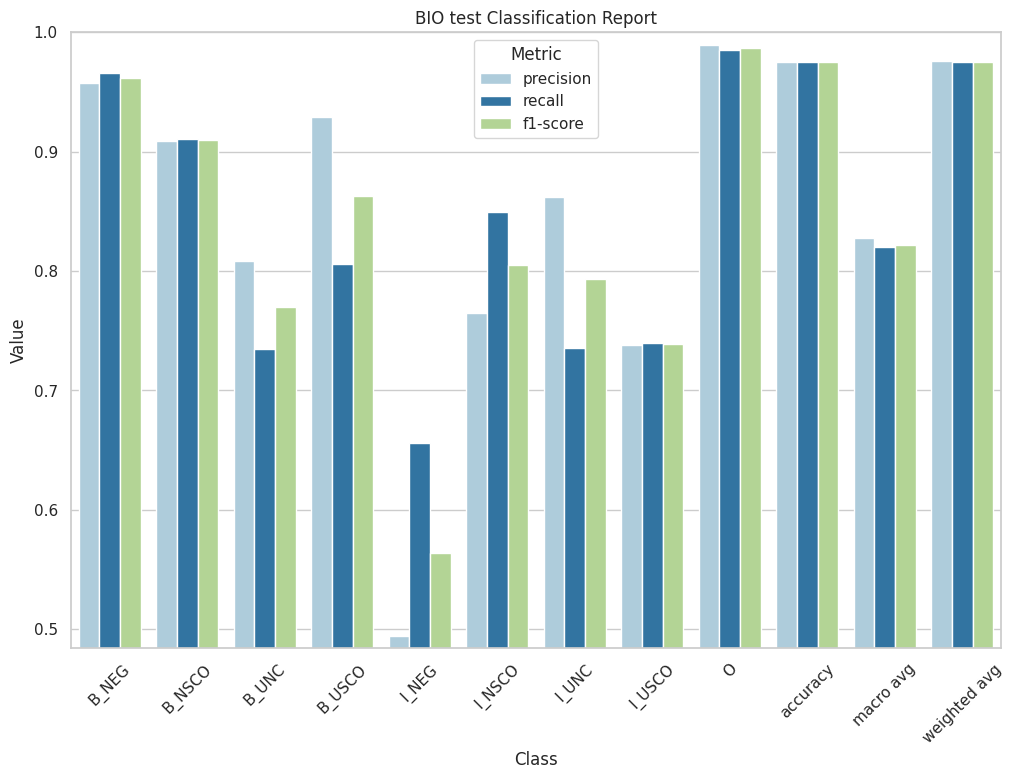

In [134]:
plot_report(report_bio_test, "BIO test")

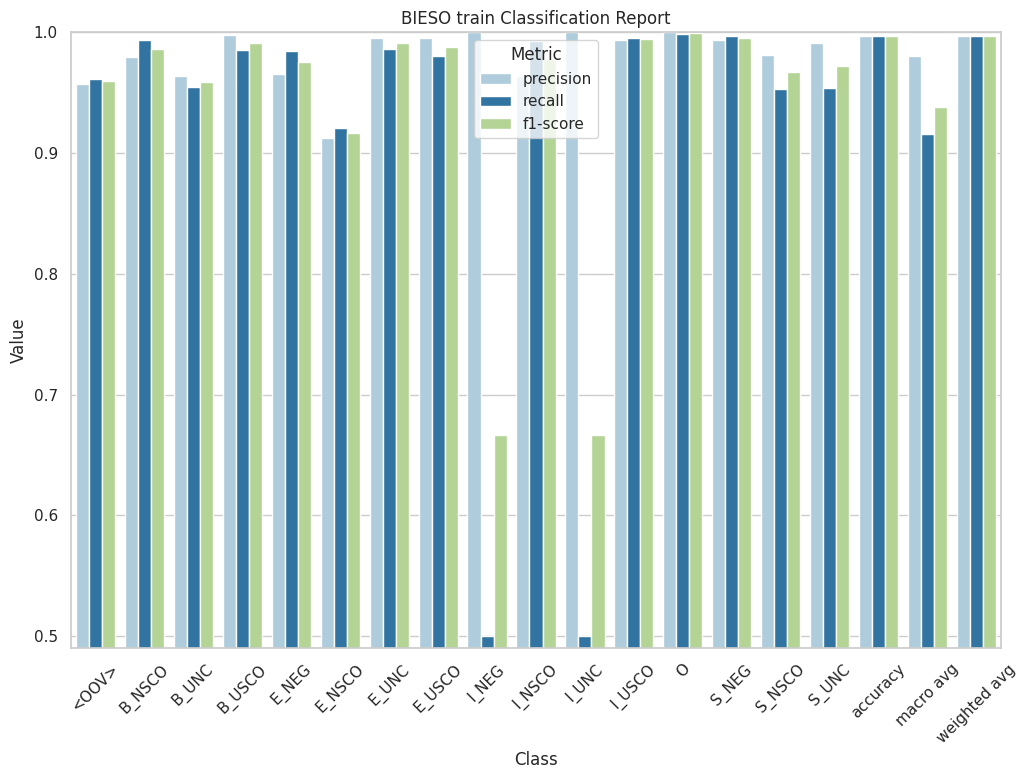

In [135]:
plot_report(report_bieso_train, "BIESO train")

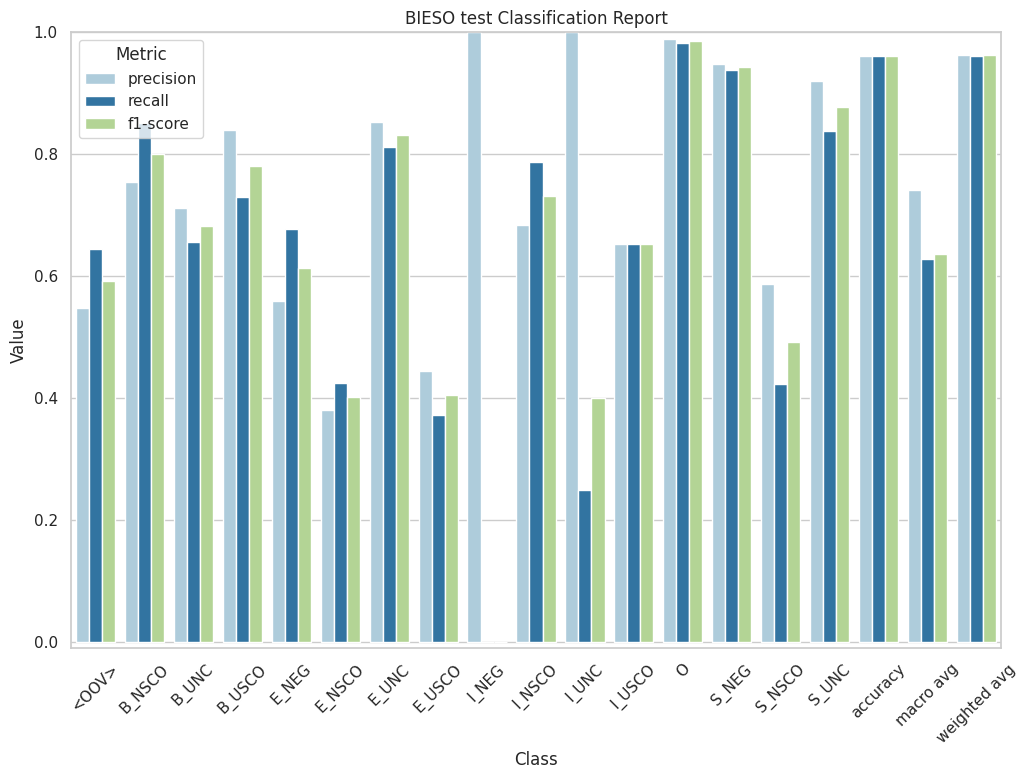

In [136]:
plot_report(report_bieso_test, "BIESO test")